In [1]:
import pandas as pd
import re
from pathlib import Path
import os
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
folder_path = Path('data/genius_data/')
artists_list = []
for filename in folder_path.iterdir():
    artis_name = re.match(r'.*/(.*).csv', str(filename)).group(1)
    artists_list.append(artis_name)

print('Liczba węzłów, artystów:', len(artists_list))

Liczba węzłów, artystów: 80


## Odczyt danych
* Dane wyciągnięto z plikóœ .csv z tekstami utowrów poszczególnych artystów, w każdym tekście zwrotka zaczyna się opisym wykonawcy który ją wykonuje, przez to możemy określić występowanie tkw. *feauteringu*, gościnnego występu innego artysty. Gdy takie zjawisko zachodzi łączymy artystów w sieci.
* źródło danych: https://www.kaggle.com/datasets/mervedin/genius-lyrics?resource=download

In [3]:
folder_path = Path('data/genius_data/')
artists_list = []
for filename in folder_path.iterdir():
    artis_name = re.match(r'.*/(.*).csv', str(filename)).group(1)
    artists_list.append(artis_name)

print('Liczba węzłów, artystów:', len(artists_list))

Liczba węzłów, artystów: 80


### Wyznaczanie sąsiedztwa

In [4]:
features = []

for filename in folder_path.iterdir():
    browsed_artist = re.match(r'.*/(.*).csv', str(filename)).group(1)
    with open(filename, 'r') as file:
        content = file.read()

    for artist in artists_list:
        if artist != browsed_artist:
            if re.search(f'\[.*: ({artist})\]', content):
                features.append((browsed_artist, artist))
len(features)

543

In [5]:
# Network creation
G = nx.Graph(features)
len(list(G.nodes())), len(list(G.edges()))

(69, 451)

## Badanie miar sieci

### Miara centralności

In [6]:
centrality_dict = nx.degree_centrality(G)

df_centrality = pd.DataFrame(sorted(centrality_dict.items(), key=lambda item:item[1], reverse=True),
    columns=['Artist', 'centrality degree'])

df_centrality = df_centrality.round(decimals=3)
df_centrality.index += 1

In [7]:
df_centrality.to_csv('data/results/centrality_table.csv')

In [8]:
print('10 artystów z najwyższą miarą centralności:')
df_centrality[:10]

10 artystów z najwyższą miarą centralności:


,Artist,centrality degree
1,Lil Wayne,0.500
2,Future,0.456
3,2 Chainz,0.426
4,Drake,0.426
5,Rick Ross,0.397
6,Big Sean,0.397
7,Nicki Minaj,0.397
8,Kanye West,0.397
9,Young Thug,0.397
10,DJ Khaled,0.382


In [9]:
print('10 artystów z najniższą miarą centralności:')
df_centrality[-10:-1]

10 artystów z najniższą miarą centralności:


,Artist,centrality degree
60,Lana Del Rey,0.044
61,SUICIDEBOY,0.044
62,Taylor Swift,0.044
63,Lady Gaga,0.029
64,Damso,0.029
65,Imagine Dragons,0.029
66,Kevin Gates,0.029
67,Nekfeu,0.029
68,Genius English Translations,0.015


### Rozkład stopni węzłów

In [10]:
import seaborn as sns
# Get the degree of each node
degree_sequence = G.degree()

# Plot the degree distribution
# sns.histplot(degree_sequence, binwidth=0.99, kde=False).set_title('Rozkład stopni węzłów')
data = list(degree_sequence)

df = pd.DataFrame(data, columns=['Node','Degree'])
df = df.sort_values(by='Degree', ascending=False)
df.reset_index(drop=True, inplace=True)
df.head()

,Node,Degree
0,Lil Wayne,34
1,Future,31
2,2 Chainz,29
3,Drake,29
4,Rick Ross,27


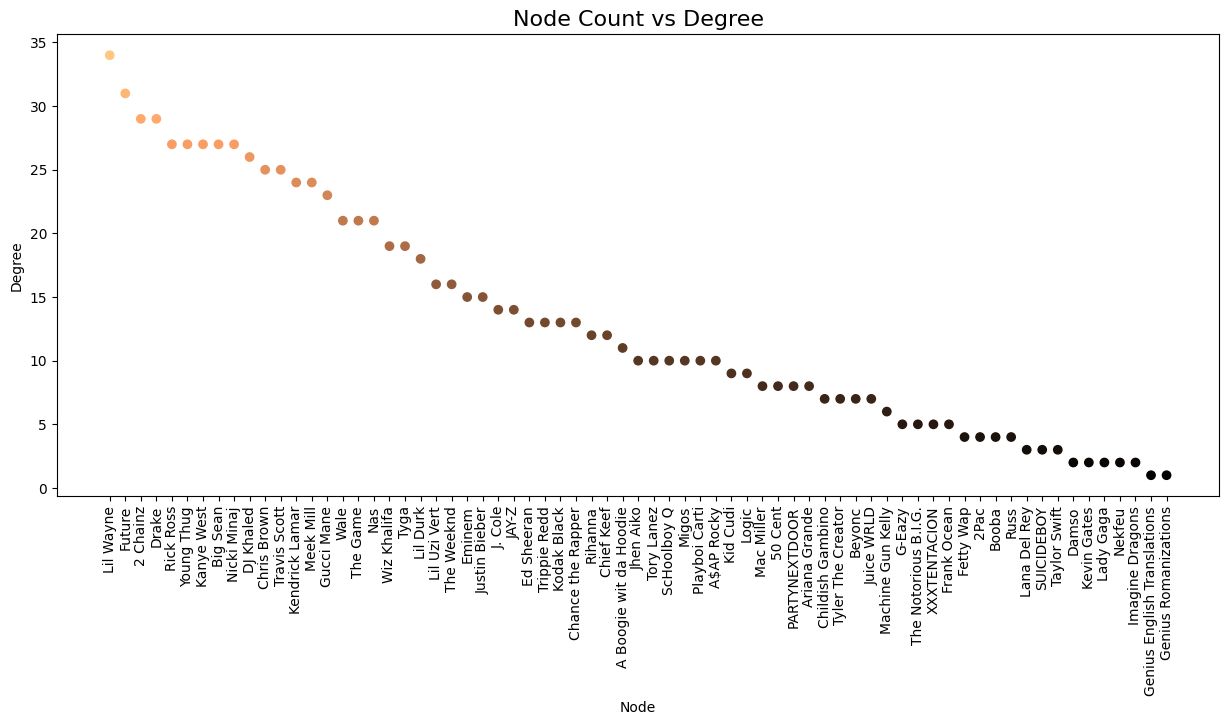

In [11]:
# Create scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(x=df['Node'], y=df['Degree'],c=df['Degree'], cmap='copper')

# Add labels and title
plt.xlabel('Node')
plt.ylabel('Degree')
plt.title('Node Count vs Degree', fontsize=16)
plt.xticks(rotation=90)

# Show plot
plt.show()

### Wyszukiwanie klik

In [14]:
count = 0
n = 10
print(f'Kliki n-tego rzędu dla n={n}')
for clique in nx.find_cliques(G):
    if len(clique) >= n:
        count += 1
        print(clique)

Kliki n-tego rzędu dla n=10
['Lil Wayne', 'Future', '2 Chainz', 'The Game', 'Chris Brown', 'Rick Ross', 'Big Sean', 'Drake', 'DJ Khaled', 'Kendrick Lamar']
['Lil Wayne', 'Future', '2 Chainz', 'Nicki Minaj', 'Chris Brown', 'Tyga', 'Rick Ross', 'Young Thug', 'Gucci Mane', 'Kanye West']
['Lil Wayne', 'Future', '2 Chainz', 'Nicki Minaj', 'Chris Brown', 'Tyga', 'Rick Ross', 'Young Thug', 'Gucci Mane', 'Drake']
['Lil Wayne', 'Future', '2 Chainz', 'Nicki Minaj', 'Chris Brown', 'DJ Khaled', 'Young Thug', 'Gucci Mane', 'Rick Ross', 'Kanye West']
['Lil Wayne', 'Future', '2 Chainz', 'Nicki Minaj', 'Chris Brown', 'DJ Khaled', 'Young Thug', 'Gucci Mane', 'Rick Ross', 'Drake']


## Wizualizacja

In [15]:
net = Network()
net.from_nx(G)
net.repulsion()
net.show('music-net.html')

In [16]:
nx.is_connected(G)

True

In [17]:
cliques = nx.find_cliques(G)

clicque_count = 0
for n, clique in enumerate(cliques):
    if len(clique) > 11:
        clicque_count += 1
        # print(clique, len(clique))
clicque_count

0

In [18]:
high_degree_nodes = [n for n,d in G.degree() if d >=10]
sub_graph = G.subgraph(high_degree_nodes)

net = Network()
net.from_nx(sub_graph)
net.repulsion()
net.show('music-net-subgraph.html')

## Eksperyment, sprawdzenie kruchości sieci
* #### Losowanie usuwanie wierzchołków tak wby rozspójnić sieć

In [19]:
nodes_list = list(G.nodes())
hubs_1 = []

def remove_until_disconnected(g):
    count = 0
    while nx.is_connected(g):
        node = random.choice(nodes_list)
        if node in g.nodes():
            g.remove_node(node)
            count += 1
    if count == 1:
        hubs_1.append(node)

    return count

disconnection_degree = []
for n in range(200):
    G_exp = G.copy()
    disconnection_degree.append(remove_until_disconnected(G_exp))

In [20]:
print('Minimalna liczba usuniętych węzłów aby rozspójnić sieć: ', min(disconnection_degree))
print('Maksymalna liczba usuniętych węzłóœ do przed rozspójnieniem sieć', max(disconnection_degree) - 1)
print('Średnia wartość k-spójności:', sum(disconnection_degree)/len(disconnection_degree))
print('Median wartości k-spójności', np.median(np.array(disconnection_degree)))

Minimalna liczba usuniętych węzłów aby rozspójnić sieć:  1
Maksymalna liczba usuniętych węzłóœ do przed rozspójnieniem sieć 58
Średnia wartość k-spójności: 16.425
Median wartości k-spójności 14.0


In [21]:
hubs_1

['Justin Bieber', 'Nicki Minaj', 'Nicki Minaj', 'Justin Bieber']